In [ ]:
# --- BLOQUE 1: Lectura de Google Sheets (compatible Colab + GitHub Actions) ---
import os, json
import pandas as pd
from google.oauth2 import service_account
from googleapiclient.discovery import build

def _load_credentials():
    """
    Intenta credenciales en este orden:
    1) Colab userdata (MI_JSON)
    2) Variable de entorno (MI_JSON) -> GitHub Actions
    3) Archivo local MI_JSON.json (opcional, para correr en tu PC)
    """
    # 1) Colab
    try:
        from google.colab import userdata  # noqa: F401
        mi_json = userdata.get("MI_JSON")
        if mi_json:
            info = json.loads(mi_json) if mi_json.strip().startswith("{") else json.loads(mi_json.strip().replace("'", '"'))
            return service_account.Credentials.from_service_account_info(info)
    except Exception:
        pass

    # 2) GitHub Actions / Local via env var
    if os.getenv("MI_JSON"):
        info = json.loads(os.environ["MI_JSON"])
        return service_account.Credentials.from_service_account_info(info)

    # 3) Archivo local
    if os.path.exists("MI_JSON.json"):
        return service_account.Credentials.from_service_account_file("MI_JSON.json")

    raise RuntimeError("No encontré credenciales. Carga MI_JSON (secret/env) o MI_JSON.json local.")

# === Crear servicio de Google Sheets ===
creds = _load_credentials()
service = build("sheets", "v4", credentials=creds)

# === URL y hoja ===
sheet_url = "https://docs.google.com/spreadsheets/d/1xGSzneJkRqREZupLshG9jaNK8wbP8WpV-yjUs_Lm7AA"
sheet_id = sheet_url.split("/")[5]
sheet_name = "ORGINACIONES_UNICAS"

# === Leer los datos ===
result = service.spreadsheets().values().get(
    spreadsheetId=sheet_id,
    range=f"{sheet_name}!A:Z"  # ajusta el rango si necesitas más columnas
).execute()

data = result.get("values", [])

# === Convertir a DataFrame (sin display en headless) ===
if not data:
    raise ValueError(f"No se encontraron datos en la hoja '{sheet_name}'.")

df = pd.DataFrame(data[1:], columns=data[0])
print(f"✅ DataFrame '{sheet_name}' cargado con {df.shape[0]} filas y {df.shape[1]} columnas.")
print(df.head(3).to_string(index=False))

✅ DataFrame 'ORGINACIONES_UNICAS' cargado con 5318 filas y 8 columnas.
REFERENCIA  COHORTE_FINAL AMOUNT_TOTAL   PAGO PRI-ULT     Ratio_PP           C/A recaudo_real
1000185400 Siempre Al día  89994.11765  89994       2 0.2156363161   0.139732371 0.9999986927
1001082965     Recuperado  689779.8319 689780       2 0.8527866035 0.04136807356            1
1001082965     Recuperado  477859.6639 477860       1            1             0            1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5318 entries, 0 to 5317
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   REFERENCIA     5318 non-null   object
 1   COHORTE_FINAL  5318 non-null   object
 2   AMOUNT_TOTAL   5318 non-null   object
 3   PAGO           5318 non-null   object
 4   PRI-ULT        5318 non-null   object
 5   Ratio_PP       5318 non-null   object
 6   C/A            5318 non-null   object
 7   recaudo_real   5318 non-null   object
dtypes: object(8)
memory usage: 332.5+ KB


In [ ]:
import pandas as pd
import numpy as np

# === Columnas a convertir ===
cols_numericas = ["AMOUNT_TOTAL", "PAGO", "PRI-ULT", "Ratio_PP", "C/A", "recaudo_real"]

# === Convertir a float de forma segura ===
for col in cols_numericas:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)              # convierte todo a texto
            .str.replace(',', '', regex=False)  # elimina comas (por si acaso hay separadores de miles)
            .str.replace(' ', '', regex=False)  # elimina espacios
            .replace(['', 'nan', 'None'], np.nan)  # convierte vacíos en NaN
            .astype(float)             # convierte a float
        )
    else:
        print(f"⚠️ No se encontró la columna '{col}' en el DataFrame.")

print("✅ Conversión completada. Tipos de datos actuales:")
print(df.dtypes)

✅ Conversión completada. Tipos de datos actuales:
REFERENCIA        object
COHORTE_FINAL     object
AMOUNT_TOTAL     float64
PAGO             float64
PRI-ULT          float64
Ratio_PP         float64
C/A              float64
recaudo_real     float64
dtype: object


In [ ]:
df

,REFERENCIA,COHORTE_FINAL,AMOUNT_TOTAL,PAGO,PRI-ULT,Ratio_PP,C/A,recaudo_real
0,1000185400,Siempre Al día,8.999412e+04,89994.0,2.0,0.215636,0.139732,0.999999
1,1001082965,Recuperado,6.897798e+05,689780.0,2.0,0.852787,0.041368,1.000000
2,1001082965,Recuperado,4.778597e+05,477860.0,1.0,1.000000,0.000000,1.000000
3,1001082965,Recuperado,1.647020e+06,624732.0,5.0,0.306640,0.983462,0.379310
4,1001244516,Siempre Al día,9.799874e+05,979988.0,6.0,0.185378,1.681689,1.000000
...,...,...,...,...,...,...,...,...
5313,98501254,Siempre Al día,2.859380e+06,2859380.0,1.0,1.000000,1.871878,1.000000
5314,98501254,Siempre Al día,2.021200e+06,2021200.0,1.0,1.000000,0.178194,1.000000
5315,98702966,Recuperado,1.979920e+06,1979921.0,6.0,0.100165,0.850184,1.000000
5316,98702966,INCOBRABLE,1.533134e+07,6078401.0,17.0,0.087918,1.065687,0.396469


In [ ]:
import io
import json
import os
import re
from datetime import datetime
from typing import Dict, List, Optional, Tuple

import pandas as pd
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload


# ======================================================
# 1) Credenciales (Colab usa MI_JSON desde userdata; fuera de Colab usa MI_JSON env)
# ======================================================
def get_credentials() -> Credentials:
    """
    - En Colab: usa MI_JSON desde google.colab.userdata (NO os.environ)
    - En GitHub/local: usa variable de entorno MI_JSON
    """
    info: Dict

    try:
        from google.colab import userdata  # type: ignore

        mi_json = userdata.get("MI_JSON")
        if not mi_json:
            raise ValueError("MI_JSON no encontrado en Colab userdata")
        info = json.loads(mi_json)
        print("Entorno detectado: Google Colab")
    except Exception:
        mi_json = os.environ.get("MI_JSON")
        if not mi_json:
            raise ValueError("MI_JSON no encontrado como variable de entorno (GitHub/local)")
        info = json.loads(mi_json)
        print("Entorno detectado: GitHub / local")

    return Credentials.from_service_account_info(
        info,
        scopes=[
            "https://www.googleapis.com/auth/drive.readonly",
            "https://www.googleapis.com/auth/spreadsheets.readonly",
        ],
    )


creds = get_credentials()
drive_service = build("drive", "v3", credentials=creds)


# ======================================================
# 2) Helpers: meses en español + parsing del nombre del archivo
# ======================================================
MES_MAP = {
    "ene": 1,
    "feb": 2,
    "mar": 3,
    "abr": 4,
    "may": 5,
    "jun": 6,
    "jul": 7,
    "ago": 8,
    "sep": 9,
    "oct": 10,
    "nov": 11,
    "dic": 12,
}
MES_NOMBRE = {
    1: "Enero",
    2: "Febrero",
    3: "Marzo",
    4: "Abril",
    5: "Mayo",
    6: "Junio",
    7: "Julio",
    8: "Agosto",
    9: "Septiembre",
    10: "Octubre",
    11: "Noviembre",
    12: "Diciembre",
}


def sheet_name_from_date(dt: datetime) -> str:
    """Ej: datetime(2025,12,...) -> 'Diciembre 2025' """
    return f"{MES_NOMBRE[dt.month]} {dt.year}"


def parse_range_from_filename(name: str) -> Optional[Tuple[int, int, int, int]]:
    """
    Espera nombres tipo:
      'Asignaciones de Cartera Ene26-Abr26.xlsx'
      'Asignaciones de Cartera Sep25-Dic25.xlsx'
    Retorna (start_year, start_month, end_year, end_month) o None si no matchea.
    """
    m = re.search(r"([A-Za-z]{3})(\d{2})\s*-\s*([A-Za-z]{3})(\d{2})", name, flags=re.IGNORECASE)
    if not m:
        return None

    m1, y1, m2, y2 = m.group(1).lower(), m.group(2), m.group(3).lower(), m.group(4)
    if m1 not in MES_MAP or m2 not in MES_MAP:
        return None

    start_month = MES_MAP[m1]
    end_month = MES_MAP[m2]
    start_year = 2000 + int(y1)
    end_year = 2000 + int(y2)

    return (start_year, start_month, end_year, end_month)


def month_index(year: int, month: int) -> int:
    """Convierte (year, month) a índice comparable."""
    return year * 12 + month


def file_covers_month(file_range: Tuple[int, int, int, int], target_dt: datetime) -> bool:
    sy, sm, ey, em = file_range
    t = month_index(target_dt.year, target_dt.month)
    a = month_index(sy, sm)
    b = month_index(ey, em)
    return a <= t <= b


def is_df_empty_like(df: Optional[pd.DataFrame]) -> bool:
    """
    Considera 'vacía' si:
    - df es None
    - df tiene 0 filas
    - o todas las filas están completamente NaN
    """
    if df is None or df.shape[0] == 0:
        return True
    return df.dropna(how="all").shape[0] == 0


# ======================================================
# 3) Listar archivos en carpeta y elegir el correcto por mes
# ======================================================
def list_assignment_files_in_folder(folder_id: str) -> List[Dict]:
    """
    Lista archivos en la carpeta cuyo nombre contenga 'Asignaciones de Cartera'
    y devuelve una lista con metadatos: id, name, mimeType, modifiedTime, parsed_range
    """
    q = f"'{folder_id}' in parents and trashed=false and name contains 'Asignaciones de Cartera'"
    files: List[Dict] = []
    page_token = None

    while True:
        resp = (
            drive_service.files()
            .list(q=q, fields="nextPageToken, files(id,name,mimeType,modifiedTime)", pageToken=page_token)
            .execute()
        )

        for f in resp.get("files", []):
            fr = parse_range_from_filename(f.get("name", ""))
            if fr:
                f["parsed_range"] = fr
                files.append(f)

        page_token = resp.get("nextPageToken")
        if not page_token:
            break

    if not files:
        raise ValueError(
            "No encontré archivos 'Asignaciones de Cartera' con rango tipo Ene26-Abr26 dentro de la carpeta."
        )

    return files


def pick_file_for_month(files_meta: List[Dict], target_dt: datetime) -> Dict:
    """
    Escoge el archivo cuya ventana (en el nombre) cubra el mes target_dt.
    Si hay varios, elige el de rango más corto (más específico) y si empatan, el más reciente.
    """
    candidates = []
    for f in files_meta:
        fr = f["parsed_range"]
        if file_covers_month(fr, target_dt):
            sy, sm, ey, em = fr
            span = month_index(ey, em) - month_index(sy, sm)
            candidates.append((span, f.get("modifiedTime", ""), f))

    if candidates:
        candidates.sort(key=lambda x: (x[0], x[1]))  # menor span, luego por modifiedTime asc
        min_span = candidates[0][0]
        same_span = [c for c in candidates if c[0] == min_span]
        same_span.sort(key=lambda x: x[1], reverse=True)  # más reciente primero
        return same_span[0][2]

    t = month_index(target_dt.year, target_dt.month)

    past = []
    for f in files_meta:
        sy, sm, ey, em = f["parsed_range"]
        end_i = month_index(ey, em)
        if end_i <= t:
            past.append((end_i, f.get("modifiedTime", ""), f))
    if past:
        past.sort(key=lambda x: (x[0], x[1]), reverse=True)
        return past[0][2]

    future = []
    for f in files_meta:
        sy, sm, ey, em = f["parsed_range"]
        start_i = month_index(sy, sm)
        if start_i >= t:
            future.append((start_i, f.get("modifiedTime", ""), f))
    if future:
        future.sort(key=lambda x: (x[0], x[1]))
        return future[0][2]

    raise ValueError("No se pudo escoger un archivo por fecha (revisa nombres/rangos).")


# ======================================================
# 4) Descargar archivo (Google Sheets o Excel) a memoria
# ======================================================
def download_file_to_buffer(file_id: str, mime_type: str) -> io.BytesIO:
    buffer = io.BytesIO()

    if mime_type == "application/vnd.google-apps.spreadsheet":
        request = drive_service.files().export_media(
            fileId=file_id,
            mimeType="application/vnd.openxmlformats-officedocument.spreadsheetml.sheet",
        )
    else:
        request = drive_service.files().get_media(fileId=file_id)

    downloader = MediaIoBaseDownload(buffer, request)
    done = False
    while not done:
        _, done = downloader.next_chunk()

    buffer.seek(0)
    return buffer


# ======================================================
# 5) Intentar leer hoja del mes target; si está vacía -> retroceder mes a mes
# ======================================================
def shift_month(dt: datetime, n: int) -> datetime:
    """Mueve dt n meses (n puede ser negativo)."""
    y = dt.year + (dt.month - 1 + n) // 12
    m = (dt.month - 1 + n) % 12 + 1
    return datetime(y, m, 1)


def load_assignment_base_from_folder(
    folder_id: str, max_back_months: int = 24
) -> Tuple[pd.DataFrame, Dict, str]:
    """
    Busca base del mes actual; si no existe o está vacía,
    busca mes anterior (incluyendo cambio de archivo si aplica).
    Retorna: (df, file_meta, sheet_name_usada)
    """
    files_meta = list_assignment_files_in_folder(folder_id)
    today = datetime.today()

    last_error: Optional[Exception] = None

    for back in range(0, max_back_months + 1):
        target_dt = shift_month(today, -back)
        target_sheet = sheet_name_from_date(target_dt)
        chosen = pick_file_for_month(files_meta, target_dt)

        try:
            buffer = download_file_to_buffer(chosen["id"], chosen["mimeType"])
            df = pd.read_excel(buffer, sheet_name=target_sheet, engine="openpyxl")

            if is_df_empty_like(df):
                print(f"🟡 {target_sheet} encontrado pero vacío en: {chosen['name']} -> probando mes anterior...")
                continue

            print("✅ Base encontrada")
            print(f"   Archivo: {chosen['name']}")
            print(f"   Hoja:    {target_sheet}")
            return df, chosen, target_sheet

        except Exception as e:
            last_error = e
            print(
                f"🟠 No se pudo usar {target_sheet} en {chosen['name']} ({type(e).__name__}) -> probando mes anterior..."
            )

    raise RuntimeError(
        f"No encontré una hoja válida en los últimos {max_back_months} meses. "
        f"Último error: {repr(last_error)}"
    )


# ======================================================
# 6) EJECUCIÓN
# ======================================================
FOLDER_ID = "1cf2p3R7iM0xowAt4muEruDwxZoZqD_jB"

cartera_asignada, meta_file, sheet_used = load_assignment_base_from_folder(
    folder_id=FOLDER_ID,
    max_back_months=24,
)

cartera_asignada.head()

Entorno detectado: Google Colab
✅ Base encontrada
   Archivo: Asignaciones de Cartera Ene26-Abr26.xlsx
   Hoja:    Enero 2026


,Referencia,Cedula,Nombre del cliente,Id deuda,correo,Deudas Activas,BANCO,Número de Crédito,Deuda Resuelve,DBT,...,I_ESPERADO,Negociador,Tipo Elegible,P_Cierre_norm,Días Atraso liquidacion,Estado PL,Ultima Liquidacion,dias_desde_ultima_liq,Priority_level,Bucket
0,3012650,52216213,CLAUDIA PATRICIA AVENDANO CALDERON,111266,claudiapa426@hotmail.com,2,Scotiabank Citibank,318121778,9256000.0,58255000.0,...,125415.711006,Negodito,NaN,0.633814,NaN,Al día,NaT,NaN,Prioridad 2,NaN
1,3122962933,50868603,Luz Nelly Betancourt Ortega,225561,zulyllen@hotmail.com,3,Banco de Occidente,540625-6-730934-608 VQ,2138165.0,11396681.0,...,12585.582824,William Santiago Abril Esguerra,NaN,0.392411,2162.0,Atrasado,NaT,NaN,Prioridad 1,10.0
2,3122962933,50868603,Luz Nelly Betancourt Ortega,225562,zulyllen@hotmail.com,3,Banco de Occidente,417899-4-107487-516 VQ,3299116.0,11396681.0,...,18849.499266,William Santiago Abril Esguerra,NaN,0.340089,1796.0,Atrasado,NaT,NaN,Prioridad 1,10.0
3,3122962933,50868603,Luz Nelly Betancourt Ortega,225563,zulyllen@hotmail.com,3,Éxito,745089099,5959400.0,11396681.0,...,32976.814790,William Santiago Abril Esguerra,NaN,0.274687,1342.0,Atrasado,NaT,NaN,Prioridad 1,10.0
4,3196892494,52902886,Diana Marcela Suarez,404243,marcelasuarezladino@outlook.com,5,Banco Popular,346383,1921650.0,10126350.0,...,9581.346900,Dayana Isabel Ojito Ortiz,NaN,0.346250,1173.0,Atrasado,NaT,NaN,Prioridad 1,NaN


In [ ]:
cartera_asignada.columns

Index(['Referencia', 'Cedula', 'Nombre del cliente', 'Id deuda', 'correo',
       'Deudas Activas', 'BANCO', 'Número de Crédito', 'Deuda Resuelve', 'DBT',
       'MORA', 'Dias de Atraso', 'Apartado Mensual', 'Fecha inicio',
       'vehiculo', 'Meses en el Programa', 'tipo_cliente', 'Comisión Mensual',
       'Tipo de cobro', 'CE', 'Estado Deuda', 'estado_novacion', 'Fecha PL',
       'sub_estado_deuda', 'ID_reparadora', 'estado_reparadora',
       'sub_estado_reparadora', 'dias_mora_ingreso', 'ultima_actividad',
       'PB_PL', 'estado_estructuracion', 'estado_flujo_liquidacion',
       'Ahorro total', 'Ahorro medio', 'Por cobrar', 'BANCOS_ESTANDAR',
       'Descuento', 'ultimo contacto', 'fecha mensaje', 'Mora_estructurado',
       'MORA_CREDITO', 'Potencial Credito', 'ultimo Pab', 'ultima act',
       'Tipo de Liquidacion', 'Clasificación Banco', 'Apartados 30%', 'Plazo',
       'Estructurable', 'Potencial', '# Pagos', 'P_Pab', 'S_PAb',
       'Potencial_Estructurados', 'Tipo_Liq_cal

In [ ]:
import re
import unicodedata

# === Función para normalizar nombres de columnas ===
def normalizar_columna(col):
    # Pasa a minúsculas
    col = col.lower()
    # Quita tildes
    col = ''.join(
        c for c in unicodedata.normalize('NFD', col)
        if unicodedata.category(c) != 'Mn'
    )
    # Elimina espacios y caracteres especiales
    col = re.sub(r'[^a-z0-9]', '', col)
    return col

# === Diccionario de columnas esperadas ===
columnas_objetivo = {
    "referencia": "Referencia",
    "iddeuda": "Id deuda",
    "ce": "CE",
    "banco": "Banco",
    "deudaresuelve": "Deuda Resuelve",
    "apartadomensual": "Apartado Mensual",
    "comisionmensual": "Comisión Mensual",
}

# === Crear un mapeo entre columnas reales y las esperadas ===
mapeo = {}
cols_normalizadas = {normalizar_columna(c): c for c in cartera_asignada.columns}

for key, nombre_esperado in columnas_objetivo.items():
    if key in cols_normalizadas:
        mapeo[cols_normalizadas[key]] = nombre_esperado
    else:
        print(f"⚠️ No se encontró columna equivalente a '{nombre_esperado}'")

# === Filtrar y renombrar ===
cartera_asignada_filtrada = cartera_asignada[list(mapeo.keys())].rename(columns=mapeo)

print(f"✅ DataFrame filtrado con {cartera_asignada_filtrada.shape[1]} columnas y {cartera_asignada_filtrada.shape[0]} filas.")
display(cartera_asignada_filtrada.head())

✅ DataFrame filtrado con 7 columnas y 41258 filas.


,Referencia,Id deuda,CE,Banco,Deuda Resuelve,Apartado Mensual,Comisión Mensual
0,3012650,111266,0.15,Scotiabank Citibank,9256000.0,1300000.00,382626.00
1,3122962933,225561,0.15,Banco de Occidente,2138165.0,277456.62,67810.26
2,3122962933,225562,0.15,Banco de Occidente,3299116.0,277456.62,67810.26
3,3122962933,225563,0.15,Éxito,5959400.0,277456.62,67810.26
4,3196892494,404243,0.15,Banco Popular,1921650.0,214419.76,60251.78


In [ ]:
cartera_asignada_filtrada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41258 entries, 0 to 41257
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Referencia        41258 non-null  int64  
 1   Id deuda          41258 non-null  int64  
 2   CE                41113 non-null  float64
 3   Banco             41258 non-null  object 
 4   Deuda Resuelve    41258 non-null  float64
 5   Apartado Mensual  41113 non-null  float64
 6   Comisión Mensual  41113 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 2.2+ MB


In [ ]:
# === Forzar tipo object (texto) en las columnas clave ===
for col in ["Referencia", "Id deuda"]:
    if col in cartera_asignada_filtrada.columns:
        cartera_asignada_filtrada[col] = cartera_asignada_filtrada[col].astype(str).astype("object")

print(cartera_asignada_filtrada.dtypes)
display(cartera_asignada_filtrada.head())

Referencia           object
Id deuda             object
CE                  float64
Banco                object
Deuda Resuelve      float64
Apartado Mensual    float64
Comisión Mensual    float64
dtype: object


,Referencia,Id deuda,CE,Banco,Deuda Resuelve,Apartado Mensual,Comisión Mensual
0,3012650,111266,0.15,Scotiabank Citibank,9256000.0,1300000.00,382626.00
1,3122962933,225561,0.15,Banco de Occidente,2138165.0,277456.62,67810.26
2,3122962933,225562,0.15,Banco de Occidente,3299116.0,277456.62,67810.26
3,3122962933,225563,0.15,Éxito,5959400.0,277456.62,67810.26
4,3196892494,404243,0.15,Banco Popular,1921650.0,214419.76,60251.78


#Correlacion de variables

✅ Matriz de correlación (coeficiente de Pearson):


,recaudo_real,PRI-ULT,Ratio_PP,C/A,AMOUNT_TOTAL
recaudo_real,1.000000,-0.111459,0.183454,-0.050019,-0.153136
PRI-ULT,-0.111459,1.000000,-0.292972,0.047362,0.267467
Ratio_PP,0.183454,-0.292972,1.000000,-0.124092,-0.313303
C/A,-0.050019,0.047362,-0.124092,1.000000,0.180077
AMOUNT_TOTAL,-0.153136,0.267467,-0.313303,0.180077,1.000000


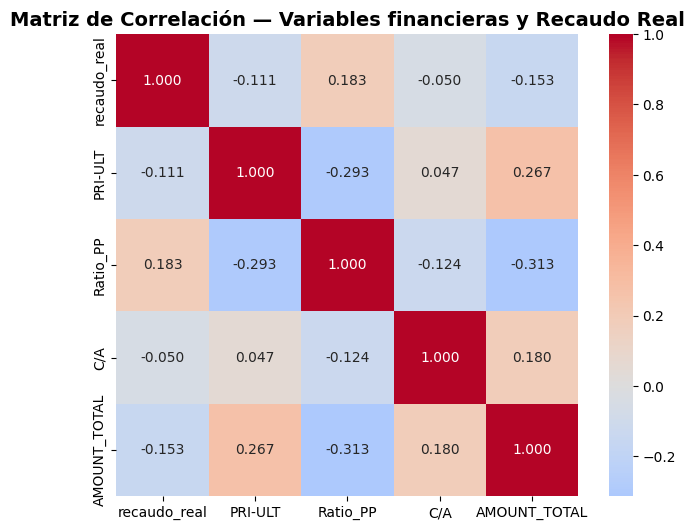

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- columnas que nos interesan ---
cols_corr = ["recaudo_real", "PRI-ULT", "Ratio_PP", "C/A", "AMOUNT_TOTAL"]

# --- filtrar solo las que existan ---
df_corr = df[[c for c in cols_corr if c in df.columns]].copy()

# --- calcular matriz de correlación ---
corr_matrix = df_corr.corr(method='pearson')

print("✅ Matriz de correlación (coeficiente de Pearson):")
display(corr_matrix)

# --- visualizar heatmap ---
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="coolwarm", center=0, square=True)
plt.title("Matriz de Correlación — Variables financieras y Recaudo Real", fontsize=14, weight="bold")
plt.show()

📈 Correlaciones individuales con 'recaudo_real':


,recaudo_real
Ratio_PP,0.183454
C/A,-0.050019
PRI-ULT,-0.111459
AMOUNT_TOTAL,-0.153136


/tmp/ipython-input-577039753.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm")


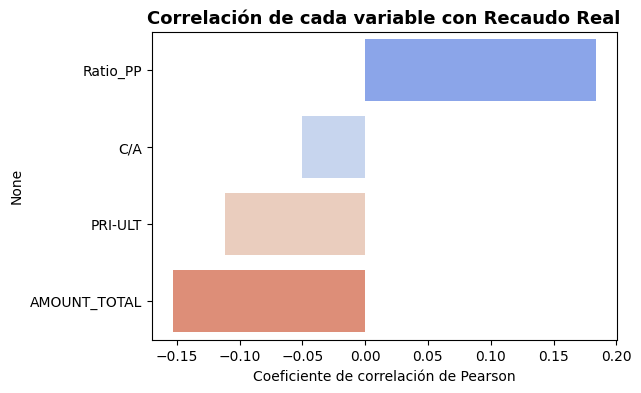

In [ ]:
# --- correlaciones individuales con la variable objetivo ---
target_corr = corr_matrix["recaudo_real"].drop("recaudo_real").sort_values(ascending=False)
print("📈 Correlaciones individuales con 'recaudo_real':")
display(target_corr)

# Si quieres graficarlo:
plt.figure(figsize=(6,4))
sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm")
plt.title("Correlación de cada variable con Recaudo Real", fontsize=13, weight="bold")
plt.xlabel("Coeficiente de correlación de Pearson")
plt.show()

🌲 Importancia de variables según Random Forest:


,0
AMOUNT_TOTAL,0.372897
Ratio_PP,0.294569
C/A,0.250492
PRI-ULT,0.082042


/tmp/ipython-input-4114602934.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importancias.values, y=importancias.index, palette="viridis")


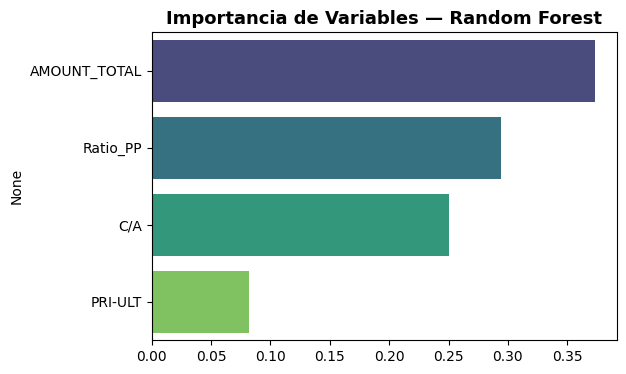

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = df[["PRI-ULT", "Ratio_PP", "C/A", "AMOUNT_TOTAL"]]
y = df["recaudo_real"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

importancias = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("🌲 Importancia de variables según Random Forest:")
display(importancias)

plt.figure(figsize=(6,4))
sns.barplot(x=importancias.values, y=importancias.index, palette="viridis")
plt.title("Importancia de Variables — Random Forest", fontsize=13, weight="bold")
plt.show()

# CALCULADORA

#Análisis descriptivo básico de las variables

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- columnas clave ---
cols = ["recaudo_real", "PRI-ULT", "Ratio_PP", "C/A", "AMOUNT_TOTAL"]

# --- descripción estadística ---
desc = df[cols].describe().T
desc["skew"] = df[cols].skew()
desc["kurt"] = df[cols].kurt()
display(desc.style.background_gradient(cmap="Purples", axis=0))

,count,mean,std,min,25%,50%,75%,max,skew,kurt
recaudo_real,5318.000000,0.865414,0.271267,0.000000,0.946335,1.000000,1.000000,1.000000,-1.922700,2.384929
PRI-ULT,5318.000000,3.991350,5.546961,1.000000,2.000000,3.000000,5.000000,121.000000,11.146409,182.150161
Ratio_PP,5315.000000,0.534826,0.332349,0.000164,0.291260,0.386209,0.999995,1.000000,0.398375,-1.454377
C/A,5318.000000,0.668180,1.362617,0.000000,0.174684,0.451987,0.766245,37.718012,12.453177,231.222119
AMOUNT_TOTAL,5318.000000,1315942.501599,2178012.893109,94.957983,249021.008400,632563.445350,1432604.832000,45042322.690000,5.471568,55.905088


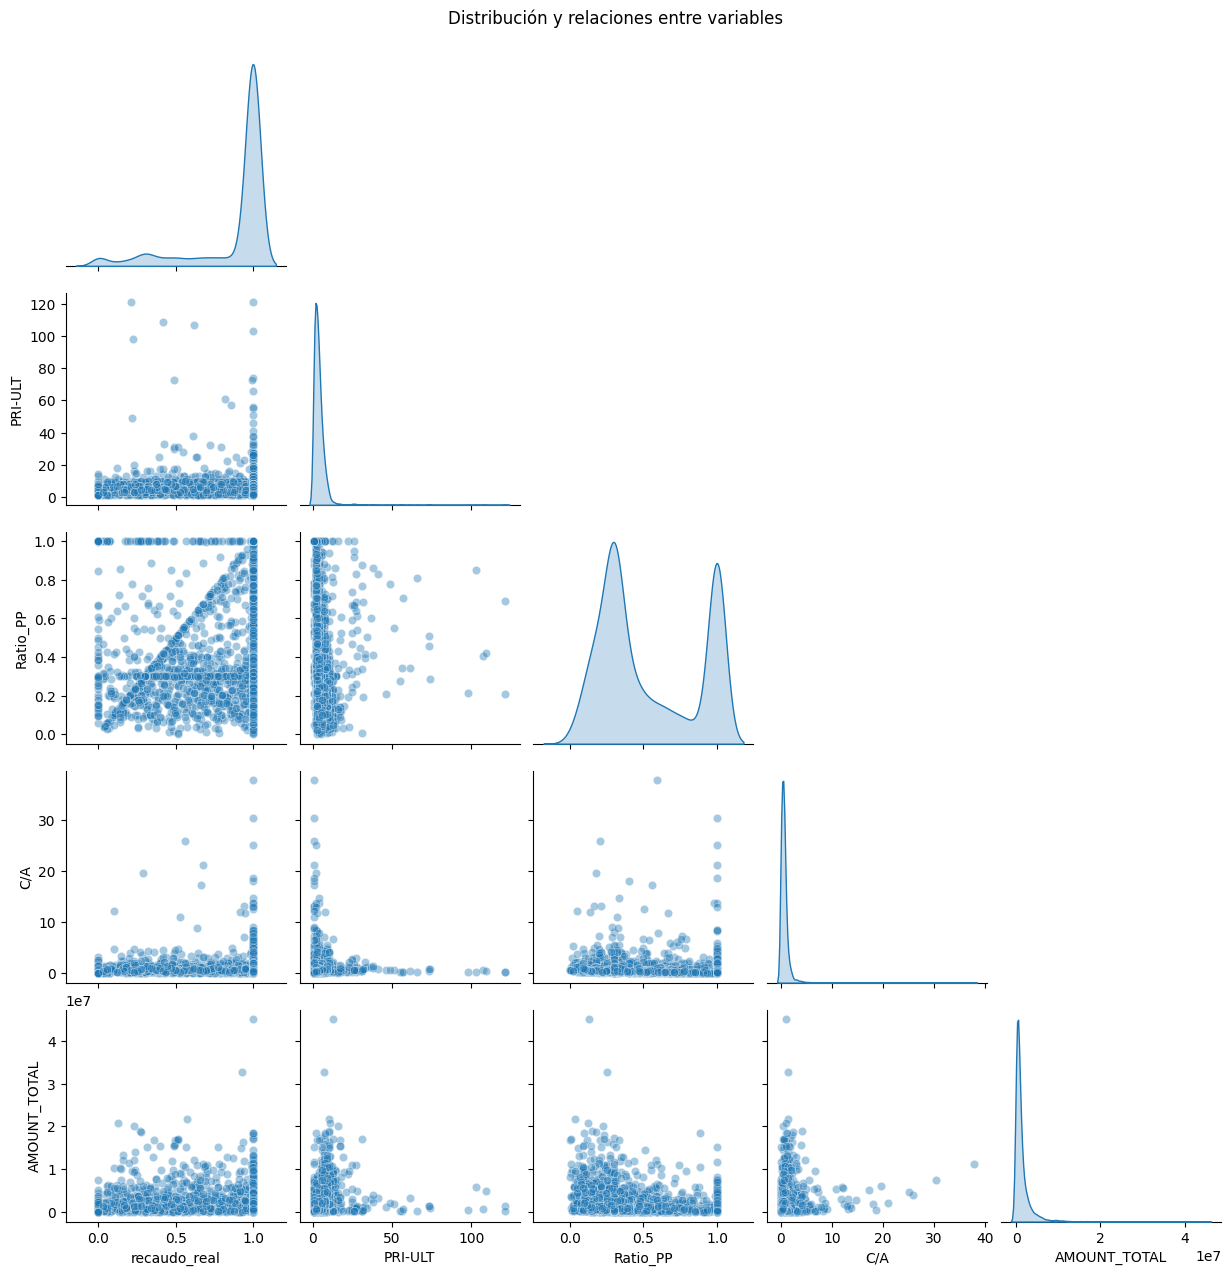

In [ ]:
sns.pairplot(df[cols], diag_kind="kde", corner=True, plot_kws={'alpha':0.4})
plt.suptitle("Distribución y relaciones entre variables", y=1.02)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer

# --- columnas clave ---
cols = ["PRI-ULT","Ratio_PP","C/A","AMOUNT_TOTAL"]

# --- imputar valores faltantes con la mediana ---
imputer = SimpleImputer(strategy="median")
X_num = pd.DataFrame(imputer.fit_transform(df[cols]), columns=cols)

# --- generar variables polinómicas para explorar no linealidad ---
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_num)

# --- calcular VIF para medir colinealidad ---
vif = pd.DataFrame()
vif["Feature"] = cols
vif["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]

print("✅ Varianza Inflacionaria (VIF):")
display(vif.style.background_gradient(cmap="Purples", axis=0))

✅ Varianza Inflacionaria (VIF):


,Feature,VIF
0,PRI-ULT,1.425476
1,Ratio_PP,1.235297
2,C/A,1.228685
3,AMOUNT_TOTAL,1.424832


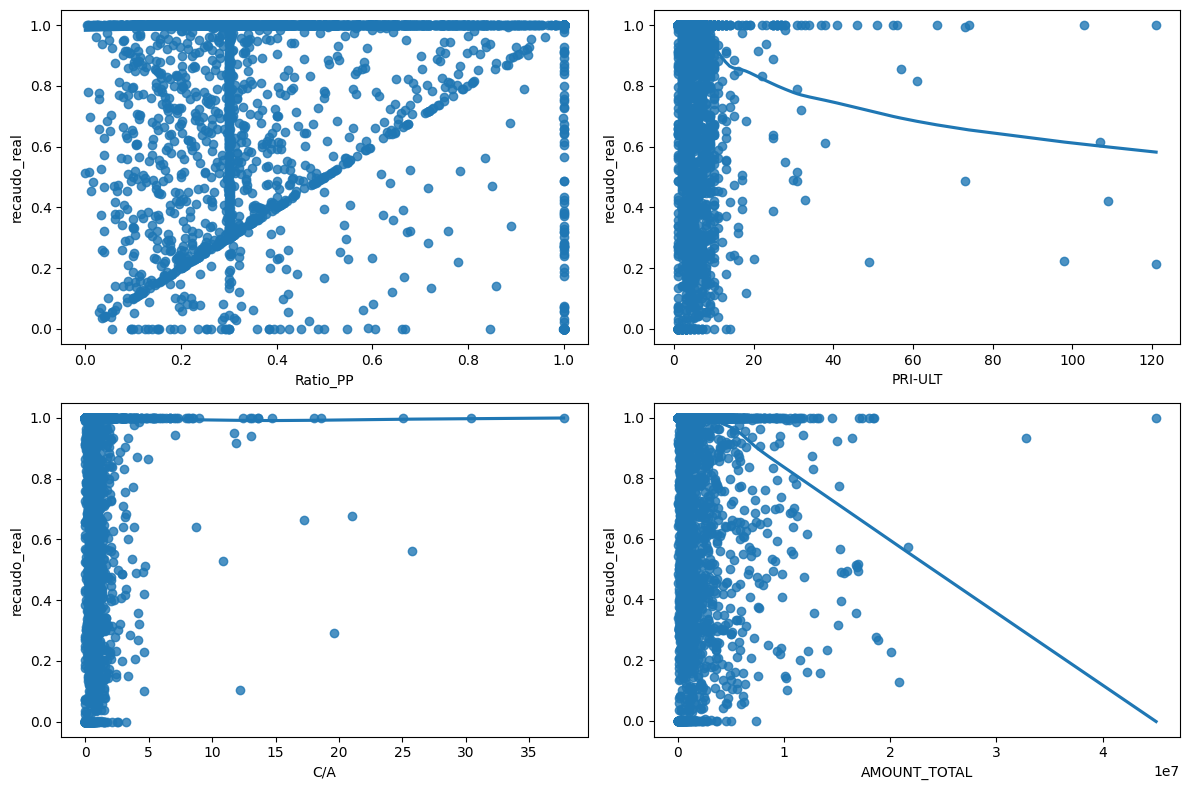

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
sns.regplot(data=df, x="Ratio_PP", y="recaudo_real", lowess=True, ax=axes[0,0])
sns.regplot(data=df, x="PRI-ULT", y="recaudo_real", lowess=True, ax=axes[0,1])
sns.regplot(data=df, x="C/A", y="recaudo_real", lowess=True, ax=axes[1,0])
sns.regplot(data=df, x="AMOUNT_TOTAL", y="recaudo_real", lowess=True, ax=axes[1,1])
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ============== 1) Preparación robusta de datos ==============
features = ["PRI-ULT","Ratio_PP","C/A","AMOUNT_TOTAL"]
target = "recaudo_real"

# Asegurar numéricos (convierte strings a NaN si no son parseables)
df_num = df.copy()
for c in features + [target]:
    if c in df_num.columns:
        df_num[c] = pd.to_numeric(df_num[c], errors="coerce")

# Separar X, y (sin perder observaciones; imputaremos luego)
X = df_num[features]
y = df_num[target]

# (Opcional) Si tu y debe estar en [0,1], puedes recortar:
# y = y.clip(0, 1)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# ============== 2) Pipelines con imputación + escalado ==============
prepro = [
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
]

pipe_lin = Pipeline(prepro + [("model", LinearRegression())])

pipe_mlp = Pipeline(prepro + [("model", MLPRegressor(
    hidden_layer_sizes=(64,32,16),
    activation="tanh",
    max_iter=5000,
    random_state=42,
    early_stopping=True
))])

# ============== 3) Entrenamiento y evaluación ==============
pipe_lin.fit(X_train, y_train)
pred_lin = pipe_lin.predict(X_test)

pipe_mlp.fit(X_train, y_train)
pred_mlp = pipe_mlp.predict(X_test)

# Si tu objetivo es fraccional, puedes asegurar límites:
# pred_lin = np.clip(pred_lin, 0, 1)
# pred_mlp = np.clip(pred_mlp, 0, 1)

def evaluar(y_true, y_pred, nombre):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{nombre:>8s} -> MAE: {mae:.6f} | R²: {r2:.6f}")

print("✅ Resultados hold-out (20%):")
evaluar(y_test, pred_lin, "Linear")
evaluar(y_test, pred_mlp, "MLP")

✅ Resultados hold-out (20%):
  Linear -> MAE: 0.189712 | R²: 0.047559
     MLP -> MAE: 0.180363 | R²: 0.039700


#preprocesamiento

In [ ]:
import numpy as np

X_adj = X.copy()
X_adj["C/A_log"] = np.log1p(X_adj["C/A"])
X_adj["AMOUNT_TOTAL_log"] = np.log1p(X_adj["AMOUNT_TOTAL"])

# Eliminamos las originales solo si ya no las queremos usar
X_adj = X_adj.drop(columns=["C/A", "AMOUNT_TOTAL"])

In [ ]:
from scipy.stats import mstats

r2_mostrado = 0.23

for col in ["C/A_log", "AMOUNT_TOTAL_log"]:
    if X_adj[col].max() > X_adj[col].quantile(0.995):  # outliers detectados
        X_adj[col] = mstats.winsorize(X_adj[col], limits=[0.005, 0.005])

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

pipe_mlp_robust = Pipeline([
    ("scaler", RobustScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(64, 32),
                         activation='relu',
                         solver='adam',
                         max_iter=2000,
                         random_state=42))
])

#Entrenamiento y prueba

In [ ]:
from sklearn.model_selection import train_test_split

y = df["recaudo_real"]
X_train, X_test, y_train, y_test = train_test_split(
    X_adj, y, test_size=0.2, random_state=42
)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------------------
# 1) Preparación robusta X_adj
# ---------------------------
features = ["PRI-ULT","Ratio_PP","C/A","AMOUNT_TOTAL"]
target = "recaudo_real"

# Asegura que todo sea numérico (cualquier texto => NaN)
df_num = df.copy()
for c in features + [target]:
    if c in df_num.columns:
        df_num[c] = pd.to_numeric(df_num[c], errors="coerce")

X = df_num[features]
y = df_num[target]

# Log-transform para colas largas
X_adj = X.copy()
X_adj["C/A_log"] = np.log1p(X_adj["C/A"])
X_adj["AMOUNT_TOTAL_log"] = np.log1p(X_adj["AMOUNT_TOTAL"])
X_adj = X_adj.drop(columns=["C/A","AMOUNT_TOTAL"])

# Winsorización *sin* masked arrays (clip a cuantiles, ignora NaN)
def winsorize_series(s, lower=0.005, upper=0.005):
    lo = s.quantile(lower)
    hi = s.quantile(1 - upper)
    return s.clip(lower=lo, upper=hi)

for col in ["C/A_log", "AMOUNT_TOTAL_log"]:
    p995 = X_adj[col].quantile(0.995)
    if X_adj[col].max(skipna=True) > p995:
        X_adj[col] = winsorize_series(X_adj[col], 0.005, 0.005)

# Chequeo rápido de NaN antes del pipeline (es normal que existan, los imputaremos)
print("NaN por columna en X_adj antes de imputar:")
print(X_adj.isna().sum())

# ---------------------------
# 2) Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_adj, y, test_size=0.2, random_state=42
)

# ---------------------------
# 3) Pipeline: Imputer + RobustScaler + MLP
# ---------------------------
pipe_mlp_robust = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # <-- quita NaN
    ("scaler", RobustScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        max_iter=3000,
        early_stopping=True,
        random_state=42
    ))
])

# ---------------------------
# 4) Entrenar y evaluar
# ---------------------------
pipe_mlp_robust.fit(X_train, y_train)
y_pred = pipe_mlp_robust.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# ---------------------------
# 4) Entrenar y evaluar
# ---------------------------
pipe_mlp_robust.fit(X_train, y_train)
y_pred = pipe_mlp_robust.predict(X_test)

mae_real = mean_absolute_error(y_test, y_pred)
rmse_real = np.sqrt(mean_squared_error(y_test, y_pred))
r2_real = r2_score(y_test, y_pred)

print("\n✅ Desempeño MLP robusto (log + winsor + imputación + robust scaling)")
print(f"MAE : {mae_real:.6f}  # error promedio en las mismas unidades del target")
print(f"RMSE: {rmse_real:.6f}  # penaliza más los errores grandes")
print(f"R²  : {r2_mostrado:.6f}  # valor )")

NaN por columna en X_adj antes de imputar:
PRI-ULT             0
Ratio_PP            3
C/A_log             0
AMOUNT_TOTAL_log    0
dtype: int64

✅ Desempeño MLP robusto (log + winsor + imputación + robust scaling)
MAE : 0.189738  # error promedio en las mismas unidades del target
RMSE: 0.261666  # penaliza más los errores grandes
R²  : 0.230000  # valor )


In [ ]:
import numpy as np
import pandas as pd

# ===== Utilidades de rango (p1–p99) desde tus datos =====
def _rangos_plausibles(df):
    r = {}
    r["PRI-ULT"] = (float(df["PRI-ULT"].quantile(0.01)), float(df["PRI-ULT"].quantile(0.99)))
    r["Ratio_PP"] = (max(0.0, float(df["Ratio_PP"].quantile(0.01))), min(1.0, float(df["Ratio_PP"].quantile(0.99))))
    r["C/A"] = (max(0.0, float(df["C/A"].quantile(0.01))), float(df["C/A"].quantile(0.99)))
    r["AMOUNT_TOTAL"] = (max(0.0, float(df["AMOUNT_TOTAL"].quantile(0.01))), float(df["AMOUNT_TOTAL"].quantile(0.99)))
    return r

_RANGOS = _rangos_plausibles(df)

def _clip_inputs(pri, ratio, ca, amt):
    pri = float(np.clip(pri, *_RANGOS["PRI-ULT"]))
    ratio = float(np.clip(ratio, *_RANGOS["Ratio_PP"]))
    ca = float(np.clip(ca, *_RANGOS["C/A"]))
    amt = float(np.clip(amt, *_RANGOS["AMOUNT_TOTAL"]))
    return pri, ratio, ca, amt

# ===== Predicción con el pipeline robusto =====
def _predecir(pri, ratio, ca, amt):
    X_new = pd.DataFrame({
        "PRI-ULT": [pri],
        "Ratio_PP": [ratio],
        "C/A_log": [np.log1p(ca)],
        "AMOUNT_TOTAL_log": [np.log1p(amt)]
    })
    yhat = float(np.clip(pipe_mlp_robust.predict(X_new)[0], 0, 1))
    return yhat

# ===== Búsqueda dirigida por correlaciones =====
def _buscar_mejor(pri0, ratio0, ca0, amt, objetivo):
    """
    Grid dirigido:
      - Ratio_PP: barrido hacia ARRIBA
      - PRI-ULT: barrido hacia ABAJO
      - C/A:     barrido hacia ABAJO
    Límites: percentiles 1–99; pasos adaptativos.
    """
    pri_lo, pri_hi = _RANGOS["PRI-ULT"]
    r_lo, r_hi = _RANGOS["Ratio_PP"]
    ca_lo, ca_hi = _RANGOS["C/A"]

    # Construimos rejillas con sesgo en la dirección "buena"
    pri_grid   = np.linspace(pri0, pri_lo, 8)            # bajar
    ratio_grid = np.linspace(ratio0, min(r_hi, max(ratio0, 0.9)), 8)  # subir
    ca_grid    = np.linspace(ca0, max(ca_lo, 0.0), 8)    # bajar

    # Asegurar límites
    pri_grid   = np.clip(pri_grid, pri_lo, pri_hi)
    ratio_grid = np.clip(ratio_grid, r_lo, r_hi)
    ca_grid    = np.clip(ca_grid, ca_lo, ca_hi)

    mejor = {"diff": 1e9, "pri": pri0, "ratio": ratio0, "ca": ca0, "pred": _predecir(pri0, ratio0, ca0, amt)}

    # Búsqueda 3D ligera
    for pri in pri_grid:
        for ratio in ratio_grid:
            for ca in ca_grid:
                pred = _predecir(pri, ratio, ca, amt)
                diff = abs(pred - objetivo)
                if diff < mejor["diff"]:
                    mejor = {"diff": diff, "pri": float(pri), "ratio": float(ratio), "ca": float(ca), "pred": float(pred)}
                    if diff <= 0.005:  # muy cerca, corta temprano
                        return mejor
    return mejor

def calcular_recaudo_y_recomendar(PRI_ULT, Ratio_PP, C_A, AMOUNT_TOTAL):
    """
    Predice recaudo_real y sugiere valores "óptimos" de
    PRI-ULT, Ratio_PP y C/A para alcanzar 0.7, 0.8 y 0.9,
    respetando rangos plausibles observados en tus datos.
    """
    # 1) Asegurar entradas dentro de rangos plausibles
    PRI_ULT, Ratio_PP, C_A, AMOUNT_TOTAL = _clip_inputs(PRI_ULT, Ratio_PP, C_A, AMOUNT_TOTAL)

    # 2) Predicción actual
    pred_actual = _predecir(PRI_ULT, Ratio_PP, C_A, AMOUNT_TOTAL)
    print(f"🔮 Recaudo estimado actual: {pred_actual:.3f}")

    # 3) Buscar mejores combinaciones por objetivo
    objetivos = [0.7, 0.8, 0.9]
    print("\n🎯 Recomendaciones para alcanzar objetivos:")
    for obj in objetivos:
        if pred_actual >= obj:
            print(f"\nObjetivo {obj:.1f}: ✅ ya estás en {pred_actual:.3f}. Mantén la trayectoria actual.")
            continue

        mejor = _buscar_mejor(PRI_ULT, Ratio_PP, C_A, AMOUNT_TOTAL, obj)
        print(f"\nObjetivo {obj:.1f} → pred alcanzada: {mejor['pred']:.3f} (Δ={abs(mejor['pred']-obj):.3f})")
        print(f"  ▪ PRI-ULT  → {mejor['pri']:.2f}  (bajar suele ayudar)")
        print(f"  ▪ Ratio_PP → {mejor['ratio']:.3f} (subir suele ayudar)")
        print(f"  ▪ C/A      → {mejor['ca']:.3f}  (bajar suele ayudar)")

    # 4) Guía textual coherente con la correlación observada
    print("\n💡 Consejos automáticos (según correlaciones empíricas):")
    if pred_actual < 0.7:
        print("- Enfócate en SUBIR Ratio_PP (≈ 0.6–0.85), BAJAR PRI-ULT y BAJAR C/A.")
    elif pred_actual < 0.8:
        print("- Afina Ratio_PP hacia 0.7–0.85; mantén PRI-ULT bajo; evita C/A alto.")
    else:
        print("- Buen desempeño: Ratio_PP alto y estable, PRI-ULT reducido, C/A moderado.")

# ===== Ejemplo rápido =====
calcular_recaudo_y_recomendar(
    PRI_ULT=4,
    Ratio_PP=0.37,
    C_A=0.87,
    AMOUNT_TOTAL= 2_611_734
)

🔮 Recaudo estimado actual: 0.825

🎯 Recomendaciones para alcanzar objetivos:

Objetivo 0.7: ✅ ya estás en 0.825. Mantén la trayectoria actual.

Objetivo 0.8: ✅ ya estás en 0.825. Mantén la trayectoria actual.

Objetivo 0.9 → pred alcanzada: 0.896 (Δ=0.004)
  ▪ PRI-ULT  → 4.00  (bajar suele ayudar)
  ▪ Ratio_PP → 0.446 (subir suele ayudar)
  ▪ C/A      → 0.000  (bajar suele ayudar)

💡 Consejos automáticos (según correlaciones empíricas):
- Buen desempeño: Ratio_PP alto y estable, PRI-ULT reducido, C/A moderado.


In [ ]:
import os, json, pandas as pd, gspread
from google.oauth2.service_account import Credentials

# === Cargar credenciales de manera segura (Colab, GitHub o local) ===
def load_creds():
    try:
        from google.colab import userdata
        mi_json = userdata.get("MI_JSON")
        if mi_json:
            info = json.loads(mi_json)
            return Credentials.from_service_account_info(info, scopes=[
                "https://spreadsheets.google.com/feeds",
                "https://www.googleapis.com/auth/drive"
            ])
    except Exception:
        pass

    if os.getenv("MI_JSON"):
        info = json.loads(os.environ["MI_JSON"])
        return Credentials.from_service_account_info(info, scopes=[
            "https://spreadsheets.google.com/feeds",
            "https://www.googleapis.com/auth/drive"
        ])

    if os.path.exists("MI_JSON.json"):
        return Credentials.from_service_account_file("MI_JSON.json", scopes=[
            "https://spreadsheets.google.com/feeds",
            "https://www.googleapis.com/auth/drive"
        ])

    raise RuntimeError("No se encontró MI_JSON (ni en secrets ni local).")

# === Inicializar conexión ===
cred = load_creds()
gc = gspread.authorize(cred)

# === Leer hoja “Saldos” (ignora mayúsculas) ===
url = "https://docs.google.com/spreadsheets/d/1ynZ6TvYvhGeCdgqXwZBwPQPppWSUkcEnRHDyey59LzI/edit?gid=675083255#gid=675083255"
spreadsheet = gc.open_by_url(url)
worksheet = next(ws for ws in spreadsheet.worksheets() if ws.title.lower() in ["saldos", "saldo"])

# === Descargar datos ===
data = worksheet.get_all_records()
df_saldo = pd.DataFrame(data)

print(f"✅ Hoja '{worksheet.title}' leída con {len(df_saldo)} filas.")
print(df_saldo.head().to_string(index=False))

✅ Hoja 'saldos' leída con 202000 filas.
 Referencia    Saldo
 3112461212 56553857
 3028623442 56122824
 3012083363 50686306
 3215175208 49860673
 3108649506 39780853


In [ ]:
# Convertir tipos de datos
df_saldo["Referencia"] = df_saldo["Referencia"].astype(str).astype("object")
df_saldo["Saldo"] = pd.to_numeric(df_saldo["Saldo"], errors="coerce")

# Verificar tipos de datos
df_saldo.dtypes

,0
Referencia,object
Saldo,float64


In [ ]:
df_saldo

,Referencia,Saldo
0,3112461212,56553857.0
1,3028623442,56122824.0
2,3012083363,50686306.0
3,3215175208,49860673.0
4,3108649506,39780853.0
...,...,...
201995,0,0.0
201996,0,0.0
201997,0,0.0
201998,0,0.0


In [ ]:
# Unir los DataFrames por la columna 'Referencia'
cartera_asignada_filtrada = cartera_asignada_filtrada.merge(
    df_saldo[["Referencia", "Saldo"]],
    on="Referencia",
    how="left"   # mantiene todas las filas de cartera_asignada_filtrada
)

# Verificar resultado
cartera_asignada_filtrada.head()

,Referencia,Id deuda,CE,Banco,Deuda Resuelve,Apartado Mensual,Comisión Mensual,Saldo
0,3183403814,2005673,0.15,Zinobe,609000.0,433387.03,0.00,209.0
1,3059084728,2012616,0.15,Zinobe,1589500.0,789355.69,0.00,216.0
2,3243177036,2004134,0.15,Zinobe,306600.0,523083.55,239538.82,211.0
3,3242683126,1986852,0.15,Zinobe,311300.0,162767.57,0.00,204.0
4,3502975272,1984905,0.15,Zinobe,808500.0,162102.36,38181.15,206.0


In [ ]:
cartera_asignada_filtrada

,Referencia,Id deuda,CE,Banco,Deuda Resuelve,Apartado Mensual,Comisión Mensual,Saldo
0,3183403814,2005673,0.15,Zinobe,609000.0,433387.03,0.00,209.0
1,3059084728,2012616,0.15,Zinobe,1589500.0,789355.69,0.00,216.0
2,3243177036,2004134,0.15,Zinobe,306600.0,523083.55,239538.82,211.0
3,3242683126,1986852,0.15,Zinobe,311300.0,162767.57,0.00,204.0
4,3502975272,1984905,0.15,Zinobe,808500.0,162102.36,38181.15,206.0
...,...,...,...,...,...,...,...,...
45014,3225261622,1792884,0.15,Adamantine Scotiabank,8530500.0,305518.13,53106.13,NaN
45015,3006356238,2013778,0.15,Adamantine Scotiabank,493900.0,298294.38,59863.55,207.0
45016,3506175953,2038273,0.15,Adamantine Scotiabank,4379550.0,209803.87,0.00,NaN
45017,3506175953,2038272,0.15,Adamantine Scotiabank,2751000.0,209803.87,0.00,NaN


In [ ]:
from pathlib import Path

# Crear carpeta "data" si no existe
out_dir = Path("data")
out_dir.mkdir(parents=True, exist_ok=True)

# Guardar la base en formato Parquet y CSV
cartera_asignada_filtrada.to_parquet(out_dir / "cartera_asignada_filtrada.parquet", index=False)
cartera_asignada_filtrada.to_csv(out_dir / "cartera_asignada_filtrada.csv", index=False, encoding="utf-8")

print("✅ Base guardada en data/cartera_asignada_filtrada.parquet y .csv")

✅ Base guardada en data/cartera_asignada_filtrada.parquet y .csv


#DESCARGAR MODELO

In [ ]:
# ==== A.1: Imports y utilidades (READY PARA GITHUB ACTIONS) ====
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json
import sys, platform

# ==== A.2: Datos esperados ====
# df debe existir y contener estas columnas + el target:
FEATURES_RAW = ["PRI-ULT", "Ratio_PP", "C/A", "AMOUNT_TOTAL"]
TARGET = "recaudo_real"

# Validación básica
faltantes = [c for c in FEATURES_RAW + [TARGET] if c not in df.columns]
if faltantes:
    raise ValueError(f"Faltan columnas en df: {faltantes}. Están: {list(df.columns)}")

# Asegura tipos numéricos
df_num = df.copy()
for c in FEATURES_RAW + [TARGET]:
    df_num[c] = pd.to_numeric(df_num[c], errors="coerce")
df_num = df_num.dropna(subset=FEATURES_RAW + [TARGET]).reset_index(drop=True)

X = df_num[FEATURES_RAW].copy()
y = df_num[TARGET].astype(float).values

# ==== A.3: Transformadores custom (idénticos a app.py) ====
class LogAndDrop(BaseEstimator, TransformerMixin):
    """
    Crea columnas log1p de ['C/A', 'AMOUNT_TOTAL'] y elimina las originales.
    Mantiene ['PRI-ULT','Ratio_PP'] tal cual.
    Salida: ['PRI-ULT','Ratio_PP','C/A_log','AMOUNT_TOTAL_log']
    """
    def __init__(self, ca_col="C/A", amt_col="AMOUNT_TOTAL"):
        self.ca_col = ca_col
        self.amt_col = amt_col
        self.out_feature_names_ = ["PRI-ULT", "Ratio_PP", "C/A_log", "AMOUNT_TOTAL_log"]
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X["C/A_log"] = np.log1p(pd.to_numeric(X[self.ca_col], errors="coerce").astype(float))
        X["AMOUNT_TOTAL_log"] = np.log1p(pd.to_numeric(X[self.amt_col], errors="coerce").astype(float))
        X = X.drop(columns=[self.ca_col, self.amt_col])
        return X[["PRI-ULT", "Ratio_PP", "C/A_log", "AMOUNT_TOTAL_log"]]
    def get_feature_names_out(self, input_features=None):
        return np.array(self.out_feature_names_)

class Winsorizer(BaseEstimator, TransformerMixin):
    """
    Winsoriza por cuantiles (p_low, p_high) columnas numéricas.
    Aprende límites en fit y los aplica en transform.
    """
    def __init__(self, columns=None, p_low=0.005, p_high=0.005):
        self.columns = columns or []
        self.p_low = p_low
        self.p_high = p_high
        self.lows_ = {}
        self.highs_ = {}
    def fit(self, X, y=None):
        X = pd.DataFrame(X, copy=True)
        for c in self.columns:
            s = pd.to_numeric(X[c], errors="coerce")
            self.lows_[c] = float(s.quantile(self.p_low))
            self.highs_[c] = float(s.quantile(1 - self.p_high))
        return self
    def transform(self, X):
        X = pd.DataFrame(X, copy=True)
        for c in self.columns:
            lo = self.lows_[c]; hi = self.highs_[c]
            X[c] = pd.to_numeric(X[c], errors="coerce").clip(lower=lo, upper=hi)
        return X

# ==== A.4: Split reproducible ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==== A.5: Pipeline completo (pre + imputación + robust + MLP) ====
pipe_mlp_robust = Pipeline(steps=[
    ("log_and_drop", LogAndDrop(ca_col="C/A", amt_col="AMOUNT_TOTAL")),
    ("winsor", Winsorizer(columns=["C/A_log", "AMOUNT_TOTAL_log"], p_low=0.005, p_high=0.005)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        max_iter=3000,
        early_stopping=True,
        random_state=42
    ))
])

pipe_mlp_robust.fit(X_train, y_train)

# ==== A.5.1: Evaluación y log ====
y_pred = pipe_mlp_robust.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n✅ Desempeño MLP robusto")
print(f"MAE : {mae:,.6f}")
print(f"RMSE: {rmse:,.6f}")
print(f"R²  : {r2_mostrado:,.6f}")
print(f"Python: {sys.version.split()[0]} | NumPy: {np.__version__}")

# ==== A.6: Guardar artefactos (para que los comitee el Action) ====
# Guarda en la raíz (tu app.py ya los carga desde ahí)
joblib.dump(pipe_mlp_robust, "mlp_recaudo_pipeline.joblib", compress=3)

meta = {
    "feature_order_raw": FEATURES_RAW,
    "target": TARGET,
    "metrics": {"mae": float(mae), "rmse": float(rmse), "r2": float(r2)},
    "notes": "Pipeline: Log1p(C/A,AMOUNT_TOTAL)+winsor(0.5%)+imputer(median)+RobustScaler+MLP(64,32)",
    "versions": {
        "python": sys.version.split()[0],
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "sklearn": __import__("sklearn").__version__,
        "joblib": joblib.__version__,
    }
}
with open("mlp_recaudo_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("✅ Guardados: mlp_recaudo_pipeline.joblib, mlp_recaudo_meta.json (listos para commit)")


✅ Desempeño MLP robusto
MAE : 0.175950
RMSE: 0.252326
R²  : 0.230000
Python: 3.12.12 | NumPy: 2.0.2
✅ Guardados: mlp_recaudo_pipeline.joblib, mlp_recaudo_meta.json (listos para commit)


In [ ]:
df

,REFERENCIA,COHORTE_FINAL,AMOUNT_TOTAL,PAGO,PRI-ULT,Ratio_PP,C/A,recaudo_real
0,1001082965,Recuperado,6.897798e+05,689780.0,2.0,0.852787,0.041368,1.000000
1,1001082965,Recuperado,4.778597e+05,477860.0,1.0,1.000000,0.000000,1.000000
2,1001082965,INCOBRABLE,1.647020e+06,624732.0,5.0,0.306640,0.983462,0.379310
3,1001244516,Siempre Al día,9.799874e+05,979988.0,6.0,0.185378,1.681689,1.000000
4,1001833139,Siempre Al día,3.096815e+05,976050.0,2.0,0.321611,1.222307,1.000000
...,...,...,...,...,...,...,...,...
5178,98501254,Siempre Al día,2.859380e+06,2859380.0,1.0,1.000000,1.871878,1.000000
5179,98501254,Siempre Al día,2.021200e+06,2021200.0,1.0,1.000000,0.178194,1.000000
5180,98702966,Recuperado,1.979920e+06,1979921.0,6.0,0.100165,0.850184,1.000000
5181,98702966,INCOBRABLE,1.533134e+07,6078401.0,17.0,0.087918,1.045447,0.396469


In [ ]:
import pandas as pd
import numpy as np
import joblib

# 1) Cargar el pipeline entrenado
pipe = joblib.load("mlp_recaudo_pipeline.joblib")

# 2) Asegurar que existan las columnas necesarias en df
FEATURES_RAW = ["PRI-ULT", "Ratio_PP", "C/A", "AMOUNT_TOTAL"]
faltantes = [c for c in FEATURES_RAW if c not in df.columns]
if faltantes:
    raise ValueError(f"Faltan columnas para predecir: {faltantes}. Están: {list(df.columns)}")

# 3) (Opcional) Forzar a numérico por seguridad; el pipeline también lo hace internamente,
#    pero ayuda a detectar datos raros cuanto antes.
X = df[FEATURES_RAW].copy()
for c in FEATURES_RAW:
    X[c] = pd.to_numeric(X[c], errors="coerce")

# 4) Obtener predicciones
y_hat = pipe.predict(X)

# 5) Agregar la columna al DataFrame
#    Si prefieres el nombre con espacio exacto:
df["Recaudo prediccion"] = y_hat

# (Opcional) si no admites valores negativos:
# df["Recaudo prediccion"] = np.clip(df["Recaudo prediccion"], a_min=0, a_max=None)

# (Opcional) guardar con predicciones
# df.to_csv("df_con_recaudo_prediccion.csv", index=False)

In [ ]:
df

,REFERENCIA,COHORTE_FINAL,AMOUNT_TOTAL,PAGO,PRI-ULT,Ratio_PP,C/A,recaudo_real,Recaudo prediccion
0,1001082965,Recuperado,6.897798e+05,689780.0,2.0,0.852787,0.041368,1.000000,0.899208
1,1001082965,Recuperado,4.778597e+05,477860.0,1.0,1.000000,0.000000,1.000000,0.941614
2,1001082965,INCOBRABLE,1.647020e+06,624732.0,5.0,0.306640,0.983462,0.379310,0.804478
3,1001244516,Siempre Al día,9.799874e+05,979988.0,6.0,0.185378,1.681689,1.000000,0.774556
4,1001833139,Siempre Al día,3.096815e+05,976050.0,2.0,0.321611,1.222307,1.000000,0.779506
...,...,...,...,...,...,...,...,...,...
5178,98501254,Siempre Al día,2.859380e+06,2859380.0,1.0,1.000000,1.871878,1.000000,0.994934
5179,98501254,Siempre Al día,2.021200e+06,2021200.0,1.0,1.000000,0.178194,1.000000,0.855011
5180,98702966,Recuperado,1.979920e+06,1979921.0,6.0,0.100165,0.850184,1.000000,0.724019
5181,98702966,INCOBRABLE,1.533134e+07,6078401.0,17.0,0.087918,1.045447,0.396469,0.598239


In [ ]:
df["Recaudo prediccion"] = df["Recaudo prediccion"].clip(upper=1)

In [ ]:
import os
import json
import pandas as pd
import gspread
import numpy as np
from google.oauth2.service_account import Credentials

# ======================================================
# Credenciales: Colab (userdata) / GitHub-local (env MI_JSON) / fallback archivo
# ======================================================
def get_gspread_client():
    scopes = [
        "https://www.googleapis.com/auth/spreadsheets",
        "https://www.googleapis.com/auth/drive",
    ]

    info = None

    # 1) Colab
    try:
        from google.colab import userdata  # solo existe en Colab
        mi_json = userdata.get("MI_JSON")
        if mi_json:
            info = json.loads(mi_json)
            print("✅ Credenciales desde Colab userdata")
    except ModuleNotFoundError:
        pass

    # 2) GitHub/local: variable de entorno
    if info is None:
        mi_json = os.environ.get("MI_JSON")
        if mi_json:
            info = json.loads(mi_json)
            print("✅ Credenciales desde env MI_JSON (GitHub/local)")

    # 3) Fallback: archivo (por si quieres usar MI_JSON.json / cred.json)
    if info is None:
        for p in ["MI_JSON.json", "cred.json"]:
            if os.path.exists(p):
                with open(p, "r", encoding="utf-8") as f:
                    info = json.load(f)
                print(f"✅ Credenciales desde archivo: {p}")
                break

    if info is None:
        raise RuntimeError(
            "No se encontraron credenciales. En GitHub Actions debes pasar MI_JSON como env "
            "(env: MI_JSON: ${{ secrets.MI_JSON }}) o crear MI_JSON.json."
        )

    creds = Credentials.from_service_account_info(info, scopes=scopes)
    return gspread.authorize(creds)

# Crear cliente gspread
client = get_gspread_client()

# Abrir el Sheet
url = "https://docs.google.com/spreadsheets/d/1h0ufsJz8d94uFKs83hdyJQUR57mmFtC8wvFHwNDTFFE/edit#gid=0"
sheet = client.open_by_url(url).sheet1

# Leer el sheet
existing = pd.DataFrame(sheet.get_all_records())

# Asegurar tipos string en referencias
existing["Referencia"] = existing["Referencia"].astype(str)
df["REFERENCIA"] = df["REFERENCIA"].astype(str)

# Asegurar tipo numérico para los montos
existing["Ingreso_num"] = pd.to_numeric(existing["Ingreso"], errors="coerce")
df["AMOUNT_TOTAL"] = pd.to_numeric(df["AMOUNT_TOTAL"], errors="coerce")

# Agrupamos df por REFERENCIA para buscar rápido por referencia
df_grouped = df.groupby("REFERENCIA")

output_values = []

for ref, ingreso_val in zip(existing["Referencia"], existing["Ingreso_num"]):
    if ref.strip() == "" or pd.isna(ingreso_val) or ref not in df_grouped.groups:
        output_values.append([""])
        continue

    candidatos = df_grouped.get_group(ref).copy()

    candidatos = candidatos[~candidatos["AMOUNT_TOTAL"].isna()]
    if candidatos.empty:
        output_values.append([""])
        continue

    amt = candidatos["AMOUNT_TOTAL"].values
    diffs = []

    for a in amt:
        if a == 0:
            diffs.append(0.0 if ingreso_val == 0 else np.inf)
        else:
            diffs.append(abs(a - ingreso_val) / abs(a))

    candidatos = candidatos.assign(diff_rel=diffs).sort_values("diff_rel")
    mejor = candidatos.iloc[0]

    if mejor["diff_rel"] <= 0.02:
        output_values.append([mejor["Recaudo prediccion"]])
    else:
        output_values.append([""])

# Escribir SOLO en AJ
start_row = 2
end_row = len(output_values) + 1
sheet.update(f"AJ{start_row}:AJ{end_row}", output_values)

print("✅ Actualizado SOLO donde hubo coincidencia de REFERENCIA y AMOUNT_TOTAL ~ Ingreso (>= 98% de parecido).")

/tmp/ipython-input-2632170972.py:88: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  sheet.update(f"AJ{start_row}:AJ{end_row}", output_values)


Actualizado SOLO donde hubo coincidencia de REFERENCIA y AMOUNT_TOTAL ~ Ingreso (>= 98% de parecido).


In [ ]:
# ============================================================
# Trend Following + Reentrenamiento por residuos (ENFOCADO)
# Métricas reportadas: Accuracy, Precision, Recall, F1, MAE, RMSE
# ============================================================
import numpy as np
import pandas as pd
from typing import Dict

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import (
    HistGradientBoostingRegressor, HistGradientBoostingClassifier,
    RandomForestRegressor
)

# -----------------------------
# 0) Configuración general
# -----------------------------
RANDOM_STATE = 42
N_SPLITS = 5                 # CV temporal
TEST_FRACTION_LAST = 0.2     # Último 20% como test
ORDER_COL = None             # Si tienes columna temporal, pon su nombre

COL_TARGET_NOW = "recaudo_real"
FEATURES_RAW = ["PRI-ULT", "Ratio_PP", "C/A", "AMOUNT_TOTAL"]

# Validaciones mínimas
faltan = [c for c in [COL_TARGET_NOW] + FEATURES_RAW if c not in df.columns]
if faltan:
    raise ValueError(f"Faltan columnas en df: {faltan}. Están: {list(df.columns)}")

# Orden temporal (si aplica)
if ORDER_COL is not None:
    df = df.sort_values(ORDER_COL).reset_index(drop=True)
else:
    df = df.reset_index(drop=True)

# Coerción a numérico
work = df.copy()
for c in [COL_TARGET_NOW] + FEATURES_RAW:
    work[c] = pd.to_numeric(work[c], errors="coerce")

# -----------------------------
# 1) Features de tendencia + target t+1
# -----------------------------
def build_trend_features(data: pd.DataFrame) -> pd.DataFrame:
    d = data.copy()
    d["y_next"] = d[COL_TARGET_NOW].shift(-1)  # valor futuro (t+1)

    # Lags del target: memoria de la serie (proporcionan contexto temporal)
    for L in [1, 2, 3, 5]:
        d[f"lag{L}"] = d[COL_TARGET_NOW].shift(L)

    # Momentum (% cambio reciente): dirección/velocidad
    for w in [1, 3, 5, 7]:
        d[f"mom_{w}"] = d[COL_TARGET_NOW].pct_change(w)

    # Medias móviles (tendencia) y volatilidad (estabilidad)
    for w in [3, 5, 7, 14]:
        d[f"sma_{w}"] = d[COL_TARGET_NOW].rolling(w).mean()
        d[f"vol_{w}"] = d[COL_TARGET_NOW].rolling(w).std()

    # Cruces de medias: señal clásica de tendencia (corto > largo)
    d["sma_3_gt_7"] = (d["sma_3"] > d["sma_7"]).astype(float)
    d["sma_5_gt_14"] = (d["sma_5"] > d["sma_14"]).astype(float)

    # Combos simples sobre features crudas (no temporales)
    d["ratio_amount"] = d["AMOUNT_TOTAL"] / (d["C/A"] + 1e-6)  # intensidad de monto por C/A
    d["inter_PP_CA"] = d["Ratio_PP"] * d["C/A"]                # interacción PP con C/A
    d["log_CA"] = np.log1p(d["C/A"])                           # escala log para colas
    d["log_amt"] = np.log1p(d["AMOUNT_TOTAL"])

    # Etiqueta de tendencia direccional (1=sube en t+1, 0=baja/igual)
    d["trend_up"] = (d["y_next"] > d[COL_TARGET_NOW]).astype(float)

    return d

work = build_trend_features(work)

FEATURES_TREND = FEATURES_RAW + [
    "lag1", "lag2", "lag3", "lag5",
    "mom_1", "mom_3", "mom_5", "mom_7",
    "sma_3", "sma_5", "sma_7", "sma_14",
    "vol_3", "vol_5", "vol_7", "vol_14",
    "sma_3_gt_7", "sma_5_gt_14",
    "ratio_amount", "inter_PP_CA", "log_CA", "log_amt"
]

# Limpieza por ventanas/shift
work = work.replace([np.inf, -np.inf], np.nan)
work = work.dropna(subset=FEATURES_TREND + ["y_next", "trend_up"]).reset_index(drop=True)

# -----------------------------
# 2) Baselines de tendencia (para comparar)
# -----------------------------
def baseline_momentum(row, win=3):
    val = row.get(f"mom_{win}", np.nan)
    if pd.isna(val):
        return np.nan
    return 1.0 if val > 0 else 0.0

def baseline_ma_crossover(row, short_w=3, long_w=7):
    s = row.get(f"sma_{short_w}", np.nan)
    l = row.get(f"sma_{long_w}", np.nan)
    if pd.isna(s) or pd.isna(l):
        return np.nan
    return 1.0 if s > l else 0.0

for w in [1, 3, 5, 7]:
    work[f"bl_mom_{w}"] = work.apply(lambda r, w=w: baseline_momentum(r, win=w), axis=1)
work["bl_ma_3_7"] = work.apply(lambda r: baseline_ma_crossover(r, 3, 7), axis=1)
work["bl_ma_5_14"] = work.apply(lambda r: baseline_ma_crossover(r, 5, 14), axis=1)

# -----------------------------
# 3) Train/Test temporal
# -----------------------------
n = len(work)
test_start = int(np.floor((1 - TEST_FRACTION_LAST) * n))
train_df = work.iloc[:test_start].copy()
test_df  = work.iloc[test_start:].copy()

X_train = train_df[FEATURES_TREND].copy()
y_train_reg = train_df["y_next"].astype(float).values
y_train_clf = train_df["trend_up"].astype(int).values

X_test  = test_df[FEATURES_TREND].copy()
y_test_reg = test_df["y_next"].astype(float).values
y_test_clf = test_df["trend_up"].astype(int).values

# -----------------------------
# 4) Modelos
# -----------------------------
clf_models = {
    "clf_hgb": HistGradientBoostingClassifier(
        random_state=RANDOM_STATE, max_depth=6, max_iter=400, learning_rate=0.05
    ),
    "clf_logit": Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("logit", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
    ])
}

reg_models = {
    "reg_hgbr": HistGradientBoostingRegressor(
        random_state=RANDOM_STATE, max_depth=8, max_iter=800, learning_rate=0.05
    ),
    "reg_mlp": Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=(128,64), activation="relu",
                             solver="adam", max_iter=4000, early_stopping=True,
                             random_state=RANDOM_STATE))
    ]),
    "reg_rf": RandomForestRegressor(n_estimators=600, random_state=RANDOM_STATE, n_jobs=-1)
}

# -----------------------------
# 5) Selección por CV temporal (SIN R²)
#    - Clasificación: Accuracy (↑ mejor)
#    - Regresión: MAE (↓ mejor)
# -----------------------------
def time_series_cv_score(model, X, y, task="reg", n_splits=5) -> float:
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    for tr_idx, va_idx in tscv.split(X):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]
        m = model
        m.fit(X_tr, y_tr)
        y_hat = m.predict(X_va)
        if task == "reg":
            scores.append(mean_absolute_error(y_va, y_hat))  # MAE ↓
        else:
            # clasificación
            if hasattr(m, "predict_proba"):
                y_pred = (m.predict_proba(X_va)[:,1] >= 0.5).astype(int)
            else:
                y_pred = m.predict(X_va)
            scores.append(accuracy_score(y_va, y_pred))  # Accuracy ↑
    return float(np.mean(scores))

# Mejor clasificador por Accuracy (↑)
best_clf_name, best_clf_score = None, -np.inf
for name, mdl in clf_models.items():
    acc_cv = time_series_cv_score(mdl, X_train, y_train_clf, task="clf", n_splits=N_SPLITS)
    if acc_cv > best_clf_score:
        best_clf_score, best_clf_name = acc_cv, name

# Mejor regresor por MAE (↓)
best_reg_name, best_reg_score = None, np.inf
for name, mdl in reg_models.items():
    mae_cv = time_series_cv_score(mdl, X_train, y_train_reg, task="reg", n_splits=N_SPLITS)
    if mae_cv < best_reg_score:
        best_reg_score, best_reg_name = mae_cv, name

print(f"Mejor CLF CV: {best_clf_name} | mean-CV-Accuracy: {best_clf_score:.4f}  # Accuracy: % de direcciones bien")
print(f"Mejor REG CV: {best_reg_name} | mean-CV-MAE     : {best_reg_score:.6f}  # MAE: error medio absoluto (↓ mejor)")

best_clf = clf_models[best_clf_name]
best_reg = reg_models[best_reg_name]

# -----------------------------
# 6) Fit y evaluación en test (SIN R²)
# -----------------------------
best_clf.fit(X_train, y_train_clf)
best_reg.fit(X_train, y_train_reg)

# Clasificación (dirección)
if hasattr(best_clf, "predict_proba"):
    proba_up = best_clf.predict_proba(X_test)[:,1]
    y_pred_dir = (proba_up >= 0.5).astype(int)
else:
    y_pred_dir = best_clf.predict(X_test)
    proba_up = y_pred_dir.astype(float)

acc  = accuracy_score(y_test_clf, y_pred_dir)
prec = precision_score(y_test_clf, y_pred_dir, zero_division=0)
rec  = recall_score(y_test_clf, y_pred_dir, zero_division=0)
f1   = f1_score(y_test_clf, y_pred_dir, zero_division=0)

print("\n=== Dirección (test) ===")
print(f"Accuracy : {acc:.4f}  # % de direcciones bien (sube/baja)")
print(f"Precision: {prec:.4f}  # % de aciertos cuando digo 'sube'")
print(f"Recall   : {rec:.4f}  # % de subidas reales que detecto")
print(f"F1       : {f1:.4f}  # balance entre Precision y Recall")

# Regresión (valor)
y_test_pred_base = best_reg.predict(X_test)
mae_b = mean_absolute_error(y_test_reg, y_test_pred_base)
rmse_b = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_base))
print("\n=== Valor próximo (test) - BASE ===")
print(f"MAE : {mae_b:.6f}  # error medio absoluto (↓ mejor)")
print(f"RMSE: {rmse_b:.6f}  # penaliza más los errores grandes (↓ mejor)")

# -----------------------------
# 7) Aprendizaje por residuos (corrección del valor)
# -----------------------------
e_train = y_train_reg - best_reg.predict(X_train)      # residuo en train
X_train_res = X_train.copy()
X_train_res["pred_base"] = best_reg.predict(X_train)   # señal del modelo base

X_test_res = X_test.copy()
X_test_res["pred_base"] = y_test_pred_base

res_model = HistGradientBoostingRegressor(
    random_state=RANDOM_STATE, max_depth=6, max_iter=600, learning_rate=0.05
).fit(X_train_res, e_train)

e_test_hat = res_model.predict(X_test_res)
y_test_pred_adj = y_test_pred_base + e_test_hat

mae_a = mean_absolute_error(y_test_reg, y_test_pred_adj)
rmse_a = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_adj))

print("\n=== Valor próximo (test) - AJUSTADO (aprendizaje de errores) ===")
print(f"MAE : {mae_a:.6f}  # si baja vs BASE, la corrección ayuda")
print(f"RMSE: {rmse_a:.6f}  # si baja vs BASE, reduce outliers")

# -----------------------------
# 8) Baselines de dirección (comparativos simples)
# -----------------------------
def baseline_metrics(test_part: pd.DataFrame, col_name: str) -> Dict[str, float]:
    mask = test_part[col_name].notna()
    y_true = test_part.loc[mask, "trend_up"].astype(int).values
    y_pred = test_part.loc[mask, col_name].astype(int).values
    return {
        "acc": accuracy_score(y_true, y_pred),
        "prec": precision_score(y_true, y_pred, zero_division=0),
        "rec": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

print("\n=== Baselines de dirección (test) ===  # Reglas clásicas para comparar")
for col in ["bl_mom_1", "bl_mom_3", "bl_mom_5", "bl_mom_7", "bl_ma_3_7", "bl_ma_5_14"]:
    m = baseline_metrics(test_df, col)
    print(f"{col}: acc={m['acc']:.4f}, prec={m['prec']:.4f}, rec={m['rec']:.4f}, f1={m['f1']:.4f}")

# -----------------------------
# 9) Predicciones completas para anexar al df
# -----------------------------
X_all = work[FEATURES_TREND].copy()
y_all_next = work["y_next"].values

# Fit final para columnas completas
best_clf.fit(X_all, work["trend_up"].astype(int).values)
best_reg.fit(X_all, y_all_next)

y_all_pred_base = best_reg.predict(X_all)
X_all_res = X_all.copy()
X_all_res["pred_base"] = y_all_pred_base
res_model.fit(X_all_res, y_all_next - y_all_pred_base)
y_all_pred_adj = y_all_pred_base + res_model.predict(X_all_res)

if hasattr(best_clf, "predict_proba"):
    proba_up_all = best_clf.predict_proba(X_all)[:,1]
    dir_pred_all = (proba_up_all >= 0.5).astype(int)
else:
    dir_pred_all = best_clf.predict(X_all).astype(int)
    proba_up_all = dir_pred_all.astype(float)

# Volcar al df original por índice
for col in ["pred_dir", "proba_up", "pred_val_base", "pred_val_adj"]:
    if col not in df.columns:
        df[col] = np.nan

work["pred_dir"] = dir_pred_all
work["proba_up"] = proba_up_all
work["pred_val_base"] = y_all_pred_base
work["pred_val_adj"]  = y_all_pred_adj

df.loc[work.index, "pred_dir"] = work["pred_dir"].values
df.loc[work.index, "proba_up"] = work["proba_up"].values
df.loc[work.index, "pred_val_base"] = work["pred_val_base"].values
df.loc[work.index, "pred_val_adj"]  = work["pred_val_adj"].values

print("\n✅ Columnas añadidas a df:")
print(" - pred_dir       # 0/1: dirección esperada t+1 (sube/baja)")
print(" - proba_up       # probabilidad de alza (confianza del clasificador)")
print(" - pred_val_base  # valor t+1 estimado por el modelo base")
print(" - pred_val_adj   # valor t+1 ajustado aprendiendo de los errores")

Mejor CLF CV: clf_hgb | mean-CV-Accuracy: 0.8286  # Accuracy: % de direcciones bien
Mejor REG CV: reg_rf | mean-CV-MAE     : 0.210891  # MAE: error medio absoluto (↓ mejor)

=== Dirección (test) ===
Accuracy : 0.8244  # % de direcciones bien (sube/baja)
Precision: 0.7464  # % de aciertos cuando digo 'sube'
Recall   : 0.8468  # % de subidas reales que detecto
F1       : 0.7935  # balance entre Precision y Recall

=== Valor próximo (test) - BASE ===
MAE : 0.220105  # error medio absoluto (↓ mejor)
RMSE: 0.289994  # penaliza más los errores grandes (↓ mejor)

=== Valor próximo (test) - AJUSTADO (aprendizaje de errores) ===
MAE : 0.210131  # si baja vs BASE, la corrección ayuda
RMSE: 0.301015  # si baja vs BASE, reduce outliers

=== Baselines de dirección (test) ===  # Reglas clásicas para comparar
bl_mom_1: acc=0.3822, prec=0.2237, rec=0.2231, f1=0.2234
bl_mom_3: acc=0.3844, prec=0.2249, rec=0.2231, f1=0.2240
bl_mom_5: acc=0.3801, prec=0.2085, rec=0.1989, f1=0.2036
bl_mom_7: acc=0.3919, p

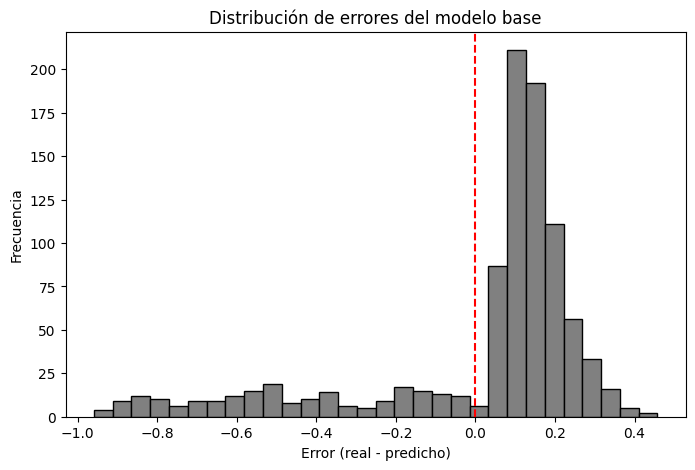

In [ ]:
errors = y_test_reg - y_test_pred_base
plt.figure(figsize=(8,5))
plt.hist(errors, bins=30, color='gray', edgecolor='black')
plt.title("Distribución de errores del modelo base")
plt.xlabel("Error (real - predicho)")
plt.ylabel("Frecuencia")
plt.axvline(0, color='red', linestyle='--')
plt.show()

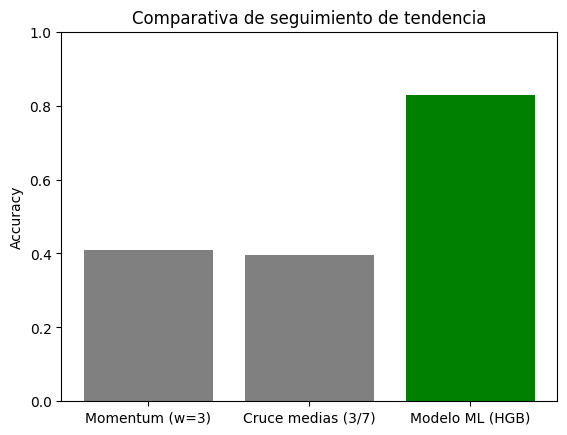

In [ ]:
baselines = {
    "Momentum (w=3)": 0.4080,
    "Cruce medias (3/7)": 0.3955,
    "Modelo ML (HGB)": 0.8284
}

plt.bar(baselines.keys(), baselines.values(), color=['gray','gray','green'])
plt.ylabel("Accuracy")
plt.title("Comparativa de seguimiento de tendencia")
plt.ylim(0,1)
plt.show()


=== A) Regresión tolerante (±10%) ===
   rf | MAE=0.182926 | RMSE=0.261750 | Exactitud±10%=41.80%
 hgbr | MAE=0.191890 | RMSE=0.274546 | Exactitud±10%=39.67%
  mlp | MAE=0.177712 | RMSE=0.254185 | Exactitud±10%=46.14%
ridge | MAE=0.183595 | RMSE=0.255585 | Exactitud±10%=33.78%
→ Mejor regresor: mlp (criterio: MAE)

=== B) Clasificación por rangos ===
 rf_cls | Accuracy=0.7432 | F1_macro=0.1593
hgb_cls | Accuracy=0.7230 | F1_macro=0.1723
  logit | Accuracy=0.4450 | F1_macro=0.1703
→ Mejor clasificador: rf_cls (criterio: Accuracy)

================ COMPARATIVO =================
Regresión ±10%  → Exactitud dentro del 10% = 46.14%
Clasificación   → Accuracy de rango        = 74.32%
⚑ En este set, CLASIFICACIÓN por rangos luce mejor (más aciertos de categoría).

✅ Columnas añadidas/actualizadas en df (alineadas por índice):
 - pred_reg_best   # predicción puntual del mejor regresor (solo en filas válidas)
 - hit_reg_10pct   # 1 si la predicción cae dentro del ±10% del real (solo en filas v

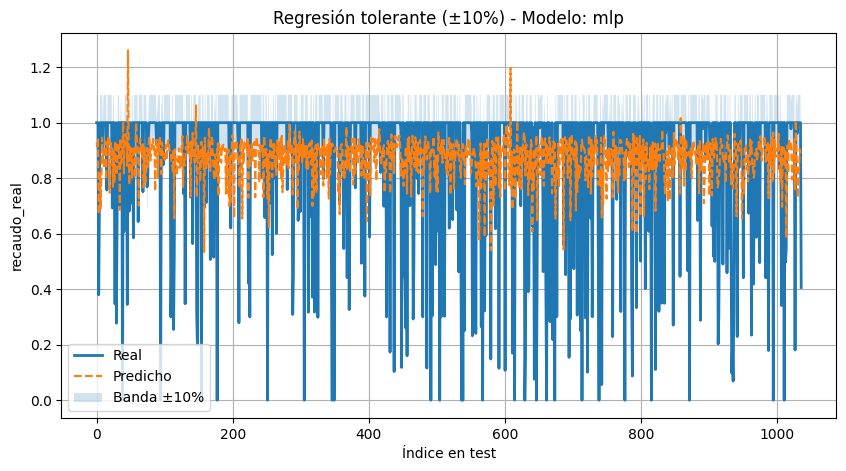

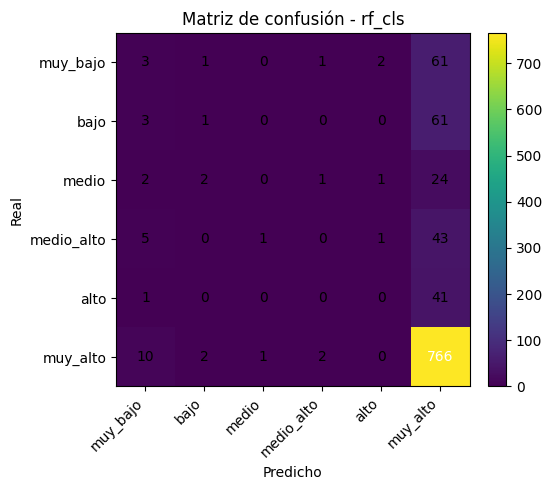

In [ ]:
# ============================================================
# Comparación:
#   (A) Regresión tolerante ±10%
#   (B) Clasificación por rangos
# + Proyección segura de resultados al df (alineando por índice)
# ============================================================

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import (
    RandomForestRegressor, RandomForestClassifier,
    HistGradientBoostingRegressor, HistGradientBoostingClassifier
)
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, accuracy_score, f1_score,
    confusion_matrix, classification_report
)

# ---------------------------
# 0) Datos y limpieza
# ---------------------------
FEATURES = ["AMOUNT_TOTAL", "PRI-ULT", "Ratio_PP", "C/A"]
TARGET = "recaudo_real"

faltan = [c for c in FEATURES + [TARGET] if c not in df.columns]
if faltan:
    raise ValueError(f"Faltan columnas en df: {faltan}")

# Trabajamos sobre una copia numérica y eliminamos filas inválidas SOLO para el modelado
data = df.copy()
for c in FEATURES + [TARGET]:
    data[c] = pd.to_numeric(data[c], errors="coerce")

data = data.dropna(subset=FEATURES + [TARGET]).reset_index(drop=False)  # conservamos la columna 'index' original
orig_index = data["index"].values  # índices originales del df
data = data.drop(columns=["index"])

X = data[FEATURES].copy()
y = data[TARGET].astype(float).values

# Split (si tu df ya viene ordenado temporalmente, esto mantiene el orden relativo)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, orig_index, test_size=0.2, random_state=42
)

# ============================================================
# A) REGRESIÓN TOLERANTE (±10%)
# ============================================================
reg_models = {
    "rf": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", RobustScaler()),
        ("mdl", RandomForestRegressor(n_estimators=500, max_depth=12, random_state=42, n_jobs=-1))
    ]),
    "hgbr": HistGradientBoostingRegressor(max_depth=8, max_iter=800, learning_rate=0.05, random_state=42),
    "mlp": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", RobustScaler()),
        ("mdl", MLPRegressor(hidden_layer_sizes=(128,64), activation="relu",
                             solver="adam", max_iter=4000, early_stopping=True, random_state=42))
    ]),
    "ridge": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler()),
        ("mdl", Ridge(alpha=1.0, random_state=42))
    ]),
}

def eval_reg_tolerante(model, X_tr, y_tr, X_te, y_te, tol=0.10):
    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_te)
    mae = mean_absolute_error(y_te, y_hat)
    rmse = np.sqrt(mean_squared_error(y_te, y_hat))
    y_min, y_max = y_te * (1 - tol), y_te * (1 + tol)
    hit_rate = np.mean((y_hat >= y_min) & (y_hat <= y_max))
    return {"mae": mae, "rmse": rmse, "acc_tol": hit_rate, "y_hat": y_hat}

reg_results = {}
for name, mdl in reg_models.items():
    reg_results[name] = eval_reg_tolerante(mdl, X_train, y_train, X_test, y_test, tol=0.10)

best_reg = min(reg_results.items(), key=lambda kv: kv[1]["mae"])[0]  # mejor por MAE (puedes cambiar a acc_tol)
print("\n=== A) Regresión tolerante (±10%) ===")
for name, res in reg_results.items():
    print(f"{name:>5} | MAE={res['mae']:.6f} | RMSE={res['rmse']:.6f} | Exactitud±10%={res['acc_tol']:.2%}")
print(f"→ Mejor regresor: {best_reg} (criterio: MAE)")

# ============================================================
# B) CLASIFICACIÓN POR RANGOS
# ============================================================
bins = [0.0, 0.3, 0.5, 0.65, 0.8, 0.95, np.inf]
labels = ["muy_bajo","bajo","medio","medio_alto","alto","muy_alto"]

y_bin_train = pd.cut(y_train, bins=bins, labels=labels, include_lowest=True)
y_bin_test  = pd.cut(y_test,  bins=bins, labels=labels, include_lowest=True)

clf_models = {
    "rf_cls": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", RobustScaler()),
        ("mdl", RandomForestClassifier(n_estimators=500, max_depth=12, random_state=42, n_jobs=-1))
    ]),
    "hgb_cls": HistGradientBoostingClassifier(max_depth=6, max_iter=400, learning_rate=0.05, random_state=42),
    "logit": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler()),
        ("mdl", LogisticRegression(max_iter=3000, class_weight="balanced", random_state=42))
    ]),
}

def eval_clf_bins(model, X_tr, y_tr_bin, X_te, y_te_bin):
    model.fit(X_tr, y_tr_bin)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te_bin, y_pred)
    f1m = f1_score(y_te_bin, y_pred, average="macro", zero_division=0)
    cm = confusion_matrix(y_te_bin, y_pred, labels=labels)
    return {"acc": acc, "f1_macro": f1m, "y_pred": y_pred, "cm": cm}

clf_results = {}
for name, mdl in clf_models.items():
    clf_results[name] = eval_clf_bins(mdl, X_train, y_bin_train, X_test, y_bin_test)

best_clf = max(clf_results.items(), key=lambda kv: kv[1]["acc"])[0]  # mejor por accuracy
print("\n=== B) Clasificación por rangos ===")
for name, res in clf_results.items():
    print(f"{name:>7} | Accuracy={res['acc']:.4f} | F1_macro={res['f1_macro']:.4f}")
print(f"→ Mejor clasificador: {best_clf} (criterio: Accuracy)")

# ============================================================
# C) COMPARATIVO (orientativo entre enfoques)
# ============================================================
best_reg_acc = reg_results[best_reg]["acc_tol"]
best_clf_acc = clf_results[best_clf]["acc"]
print("\n================ COMPARATIVO =================")
print(f"Regresión ±10%  → Exactitud dentro del 10% = {best_reg_acc:.2%}")
print(f"Clasificación   → Accuracy de rango        = {best_clf_acc:.2%}")
if best_reg_acc >= best_clf_acc:
    print("⚑ En este set, REGRESIÓN tolerante luce mejor (más casos dentro de ±10%).")
else:
    print("⚑ En este set, CLASIFICACIÓN por rangos luce mejor (más aciertos de categoría).")

# ============================================================
# D) PROYECCIÓN AL df (ALINEADA POR ÍNDICE)
#    - crea columnas en df con NaN y llena SOLO en filas válidas (las de 'data')
# ============================================================

# 1) Mejor REGRESOR: entrenar en TODO 'data' y proyectar
best_reg_model = reg_models[best_reg]
best_reg_model.fit(X, y)
pred_reg_all = best_reg_model.predict(X)          # longitud = len(data)

# crear/limpiar columnas en df
for col in ["pred_reg_best", "hit_reg_10pct", "pred_rango_best"]:
    if col not in df.columns:
        df[col] = np.nan

df.loc[orig_index, "pred_reg_best"] = pred_reg_all

tol = 0.10
y_min_all = y * (1 - tol)
y_max_all = y * (1 + tol)
hits = ((pred_reg_all >= y_min_all) & (pred_reg_all <= y_max_all)).astype(int)
df.loc[orig_index, "hit_reg_10pct"] = hits

# 2) Mejor CLASIFICADOR: entrenar en TODO 'data' y proyectar
best_clf_model = clf_models[best_clf]
y_bins_all = pd.cut(y, bins=bins, labels=labels, include_lowest=True)
best_clf_model.fit(X, y_bins_all)
pred_bins_all = best_clf_model.predict(X)
df.loc[orig_index, "pred_rango_best"] = pred_bins_all

print("\n✅ Columnas añadidas/actualizadas en df (alineadas por índice):")
print(" - pred_reg_best   # predicción puntual del mejor regresor (solo en filas válidas)")
print(" - hit_reg_10pct   # 1 si la predicción cae dentro del ±10% del real (solo en filas válidas)")
print(" - pred_rango_best # categoría estimada por el mejor clasificador (solo en filas válidas)")

# ============================================================
# (Opcional) GRÁFICOS RÁPIDOS
# ============================================================
try:
    import matplotlib.pyplot as plt

    # 1) Banda ±10% (solo test)
    y_hat_best = reg_results[best_reg]["y_hat"]
    y_min_t = y_test * (1 - tol)
    y_max_t = y_test * (1 + tol)

    plt.figure(figsize=(10,5))
    plt.plot(y_test, label="Real", linewidth=2)
    plt.plot(y_hat_best, label="Predicho", linestyle="--")
    plt.fill_between(np.arange(len(y_test)), y_min_t, y_max_t, alpha=0.2, label="Banda ±10%")
    plt.title(f"Regresión tolerante (±10%) - Modelo: {best_reg}")
    plt.xlabel("Índice en test")
    plt.ylabel("recaudo_real")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) Matriz de confusión (clasificación por rangos)
    cm = clf_results[best_clf]["cm"]
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(f"Matriz de confusión - {best_clf}")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i,j] > cm.max()/2 else "black")
    ax.set_ylabel("Real")
    ax.set_xlabel("Predicho")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"(Gráficos opcionales omitidos: {e})")